## Time Series Analysis of Car Sales 🚗
*by Arnav Akula*

### Motivation & Introduction
As a college student navigating the daunting task of buying my first car, I realized how overwhelming the car market can be. Endless options, fluctuating prices, uncertainty of whether I am getting a good deal–these issues drove me to better understand car sales and hopefully find patterns to make smarter purchasing decisions.

With time series analysis of car sales specifically, I aim to better understand the market forces at play and gain a clearer picture of **what** and **when** to buy

### Research Questions
Here are some of the research questions I aim to tackle:

**1. Are there any seasonal patterns in car sales, and how do they impact overall performance?**
- Understanding seasonal patterns can help for strategic planning, e.g. deciding when to introduce new models and phase out older ones. Identifying long-term trends enables stakeholders to better understand the broader direction of the car market at a given moment

**2. How can stochastic processes be applied to model uncertainty in car sales?**
- The car market can be affected by many external factors, leading to uncertainty in car prices. Stochastic modeling can address this uncertainty, enabling better understanding of general patterns in car sales over a more broad scale.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head()

,Make,Model,Nickname,Car Gender,Buyer Gender,Buyer Age,Buzzword,Country,City,Dealer Latitude,Dealer Longitude,Color,New Car,Purchase Date,Sale Price,Discount,Resell Price,5-yr Depreciation,Top Speed,0-60 Time
0,Suzuki,Vitara,Philippine,Female,Female,51,User-friendly,Belgium,Antwerpen,51.247239,4.440346,Yellow,False,19/07/2009,54806.14,0.2467,33858.32,0.13,200.9,11.5
1,Honda,S2000,Henrik,Male,Male,30,analyzing,China,Jinhu,33.025433,119.020584,Crimson,False,26/10/2015,51826.30,0.3147,2989.28,0.02,158.5,8.8
2,BMW,Z4,Lebbie,Male,Female,54,software,China,Gemo,30.916207,121.677640,Khaki,False,28/03/2010,82929.14,0.5414,35049.16,0.24,149.5,14.4
3,Toyota,Tacoma,Jefferey,Female,Male,68,monitoring,Portugal,Queluz de Baixo,38.745168,-9.267087,Puce,False,07/05/2008,56928.66,0.0850,8236.15,0.20,153.3,11.5
4,Ford,Festiva,Glendon,Female,Male,70,Sharable,Latvia,Jaunpils,56.729980,23.016588,Yellow,False,01/06/2008,77201.26,0.1642,32765.76,0.18,122.0,14.9


In [5]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], dayfirst=True)

In [6]:
df['Year'] = df['Purchase Date'].dt.year
df['Month'] = df['Purchase Date'].dt.to_period('M')
df['Week'] = df['Purchase Date'].dt.to_period('W')

In [7]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    
df['Season'] = df['Purchase Date'].dt.month.apply(get_season)
df['Season-Year'] = df['Season'] + ' ' + df['Year'].astype(str)

In [8]:
year_avg = df.groupby('Year')['Sale Price'].mean()
month_avg = df.groupby('Month')['Sale Price'].mean()
week_avg = df.groupby('Week')['Sale Price'].mean()
season_avg = df.groupby('Season-Year')['Sale Price'].mean()

### Plotting the data

The first step is to graph the average car sale price over various periods of time, e.g. week, month, year. Let us graph average car prices by year.

Text(0.5, 1.0, 'Average Car Sale Price by Year')

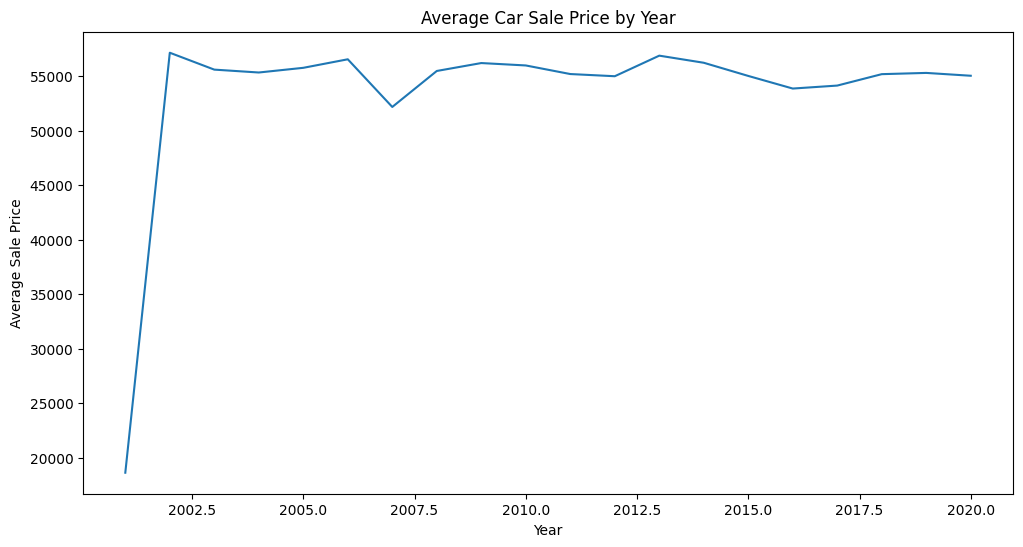

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(year_avg.index, year_avg.values, linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Sale Price')
plt.title('Average Car Sale Price by Year')

We observe a sharp increase from 2001 to 2002. From 2002 to 2020, there is little fluctuation but the car price never firmly deviates from a value of around $55,000

Let us next graph average car price over monthly periods

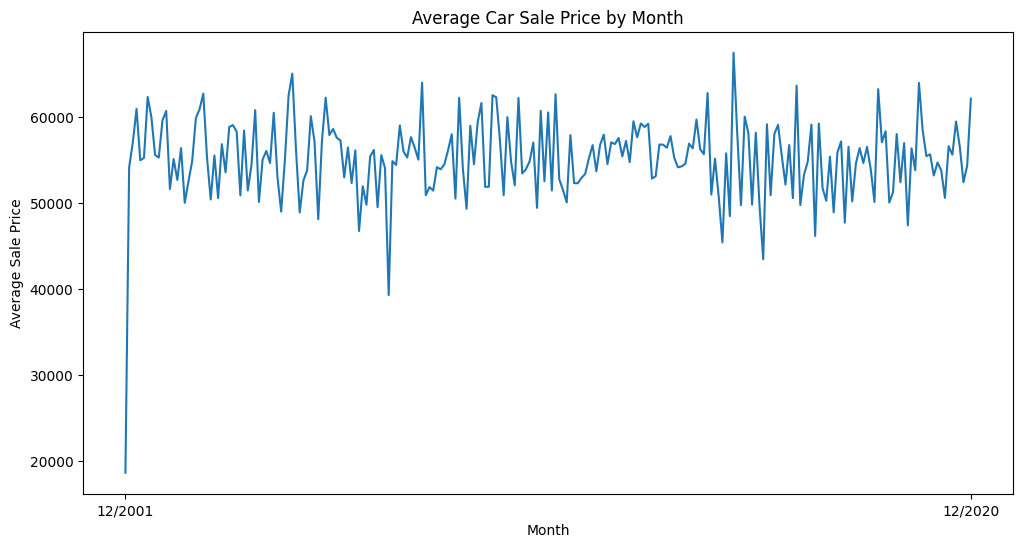

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(month_avg.index.astype(str), month_avg.values, linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Sale Price')
plt.title('Average Car Sale Price by Month')

x_ticks = [month_avg.index[0].strftime('%m/%Y'), month_avg.index[-1].strftime('%m/%Y')]
plt.xticks(ticks=[0, len(month_avg) - 1], labels=x_ticks)
plt.show()

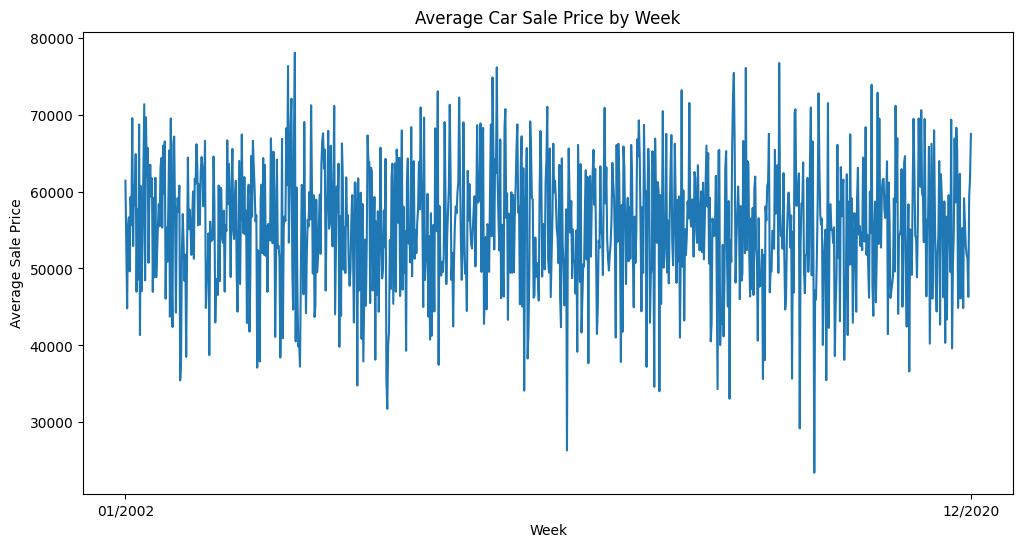

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(week_avg.index.astype(str), week_avg.values, linestyle='-')
plt.xlabel('Week')
plt.ylabel('Average Sale Price')
plt.title('Average Car Sale Price by Week')

x_ticks = [week_avg.index[0].strftime(f'%m/%Y'), week_avg.index[-1].strftime(f'%m/%Y')]
plt.xticks(ticks=[0, len(week_avg) - 1], labels=x_ticks)
plt.show()

When analyzing average car price by weekly period, we notice more noise. Again, the overall price shows a constant trend from 2001 to 2020.

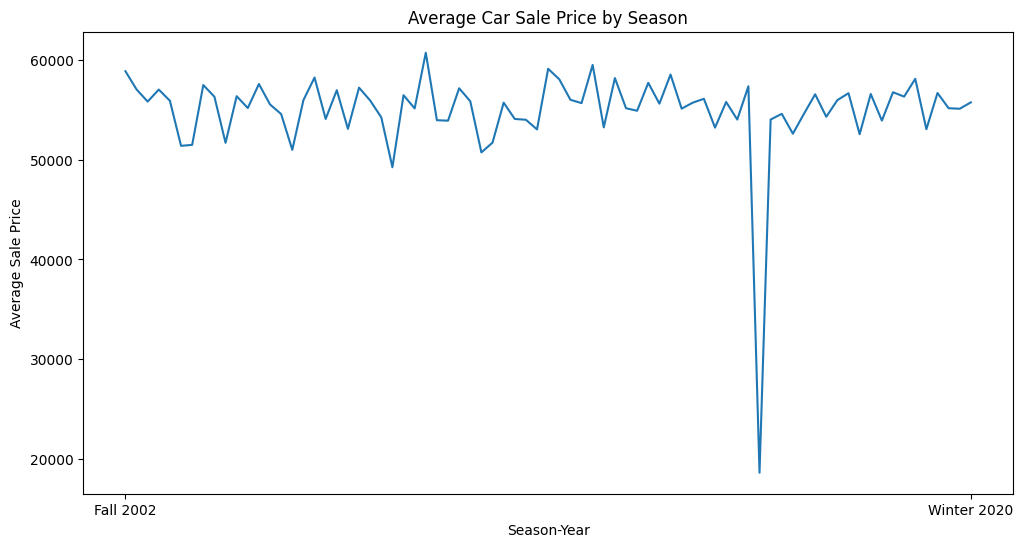

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(season_avg.index, season_avg.values, linestyle='-')
plt.xlabel('Season-Year')
plt.ylabel('Average Sale Price')
plt.title('Average Car Sale Price by Season')

plt.xticks([season_avg.index[0], season_avg.index[-1]])
plt.show()

We see a sharp decrease in car sale prices in Winter 2018. Other than that, we notice the same trends—general constant trend in the overall car and consistent variation in the time frame. We do see more consistent seasonal variation as compared to other time periods though, which is interesting to note. Why does season make more of a difference than year or week?

## Time Series Decomposition

We can perform a decomposition of our car sales data to better understand the underlying patterns. Using **statsmodels**, we will deconstruct our time series data into patterns, specifically analyzing the **seasonality**, **trend**, and **cycle**. 
- Seasonality willl tell us how car prices fluctuate based on the current season
- Trend will tell us how the overall average car price changes over time
- Cycle will tell us about patterns that exist that are not based on our season

In [13]:
ts_data = df[['Purchase Date', 'Sale Price']]
ts_data = pd.DataFrame(ts_data.groupby('Purchase Date').mean())
# ts_data = ts_data.drop(['Purchase Date'], axis=1)
ts_data = ts_data.sort_index()
ts_data.head()

,Sale Price
Purchase Date,
2001-12-31,18628.055000
2002-01-01,90846.093333
2002-01-03,49651.675000
2002-01-05,83615.660000
2002-01-07,60082.820000


### Additive Decomposition
Since our data appears to be relatively stable, we will first try an additive decomposition. Additive models are ideal for stable data with seemingly predictible fluctuations.

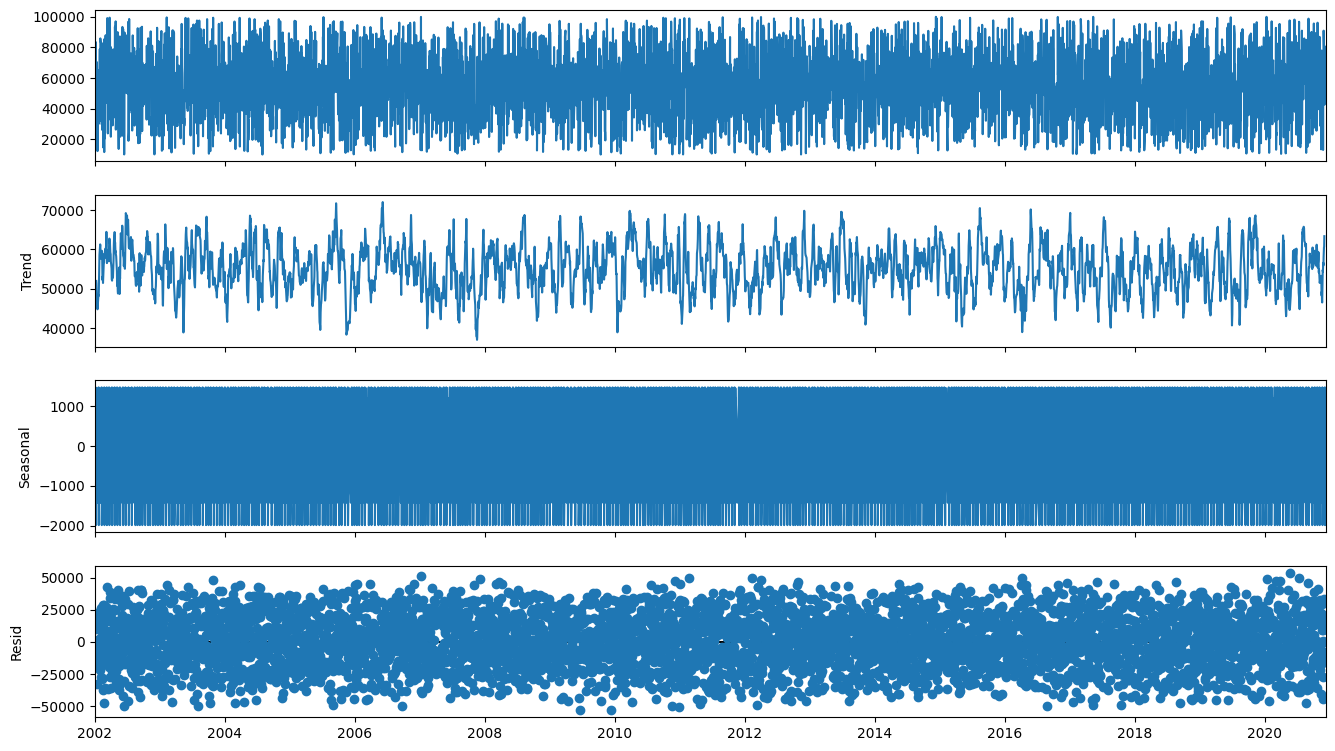

In [18]:
additive_decomp = seasonal_decompose(ts_data, model='additive', period=12)
additive_decomp.plot().set_size_inches((15, 8))


### Multiplicative Decomposition
Let us also try a multiplicative model, just to see the fit and analyze the various components of our time series data.

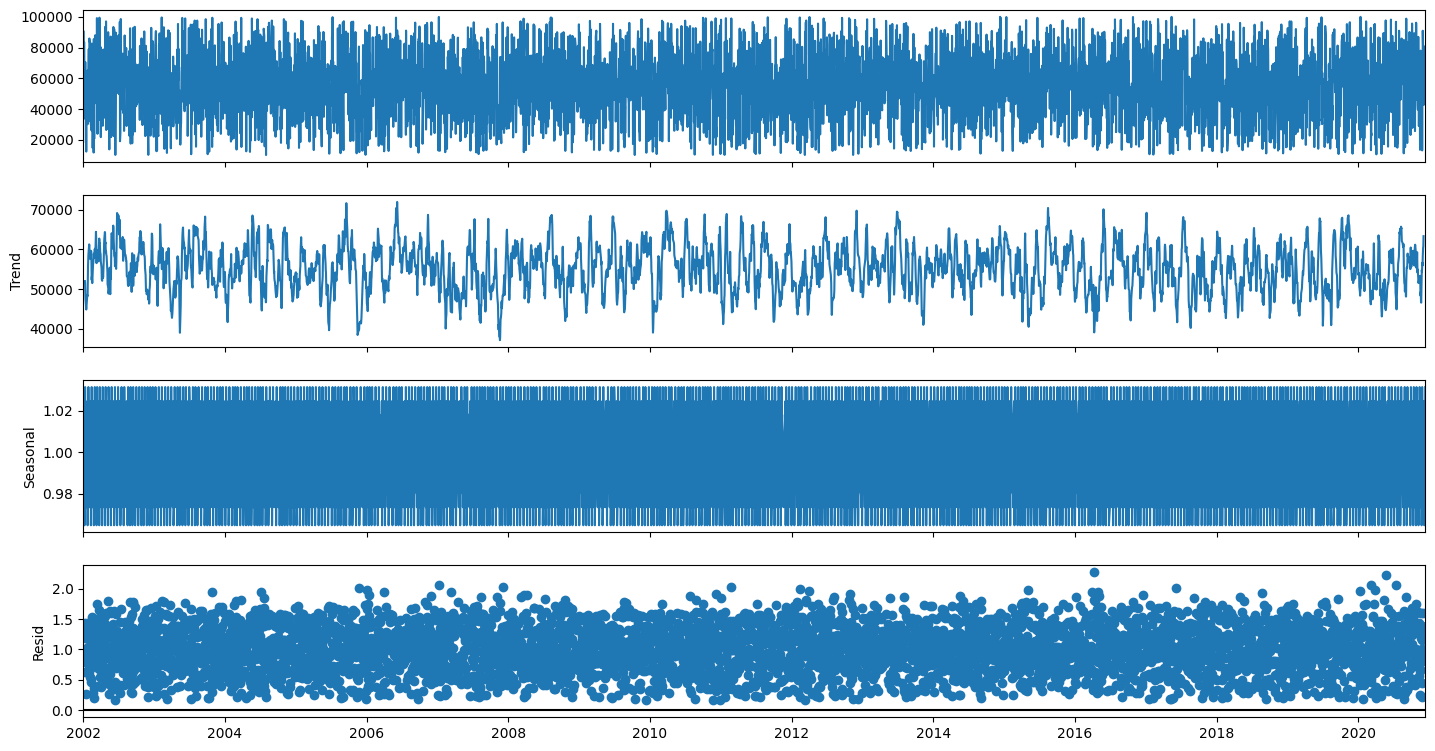

In [22]:
multiplicative_decomp = seasonal_decompose(ts_data, model='multiplicative', period=12)
multiplicative_decomp.plot().set_size_inches((16, 8))